## Requirements

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import keras_tuner as kt

## Dataset Preparation

In [81]:
df_train = pd.read_csv("data/data_train.csv", encoding='utf-8')
df_test = pd.read_csv("data/data_test.csv", encoding='utf-8')
print("Info data training awal:")
df_train.info()
print("\n")

Info data training awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 24336 non-null  int64  
 1   tanggal_waktu      24336 non-null  object 
 2   suhu               24336 non-null  float64
 3   beban_listrik      24336 non-null  float64
 4   kecepatan_angin    24336 non-null  float64
 5   tekanan_udara      24336 non-null  float64
 6   dampak_lingkungan  24336 non-null  object 
 7   konsumsi_listrik   24283 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB




## Preprocessing

In [82]:
df_train["tanggal_waktu"] = pd.to_datetime(df_train["tanggal_waktu"])
df_test["tanggal_waktu"] = pd.to_datetime(df_test["tanggal_waktu"])

In [83]:
# Cek missing values
print(df_train.isnull().sum())

ID                    0
tanggal_waktu         0
suhu                  0
beban_listrik         0
kecepatan_angin       0
tekanan_udara         0
dampak_lingkungan     0
konsumsi_listrik     53
dtype: int64


In [84]:
# Isi missing values jika ada
df_train["tekanan_udara"] = df_train["tekanan_udara"].fillna(df_train["tekanan_udara"].interpolate())
df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")

print(df_train.isnull().sum())

ID                   0
tanggal_waktu        0
suhu                 0
beban_listrik        0
kecepatan_angin      0
tekanan_udara        0
dampak_lingkungan    0
konsumsi_listrik     0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30824\1436221346.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")


In [85]:
# Encode dampak_lingkungan
df_train = pd.get_dummies(df_train, columns=["dampak_lingkungan"])
df_test = pd.get_dummies(df_test, columns=["dampak_lingkungan"])

df_train.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [86]:
# Sort sesuai dengan tanggal_waktu
df_cleaned = df_train.sort_values("tanggal_waktu")
df_test = df_test.sort_values("tanggal_waktu")
df_cleaned.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [87]:
# Cek outlier
df_cleaned.describe()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik
count,24336.000000,24336,24336.000000,24336.000000,24336.000000,24336.000000,24336.000000
mean,16027.381657,2023-07-16 19:22:53.964496896,25.161082,-1.783510,23.631823,986.012964,531.997411
min,0.000000,2021-09-17 00:00:00,12.700000,-32.900000,1.075000,953.000000,174.000000
25%,8051.750000,2022-08-18 11:45:00,21.100000,-10.700000,3.165000,977.000000,219.000000
50%,16079.500000,2023-07-18 23:30:00,25.800000,-1.400000,6.670000,986.000000,270.000000
75%,24155.250000,2024-06-19 11:15:00,29.400000,7.900000,22.700000,995.000000,342.000000
max,32183.000000,2025-05-19 23:00:00,35.300000,18.600000,586.600000,1024.000000,99999.000000
std,9299.957517,NaN,4.888658,10.521302,46.781818,12.130831,4820.776434


In [88]:
df_train_interpolated = df_cleaned.copy()

# 1. Hitung batas atas
Q1 = df_train_interpolated['konsumsi_listrik'].quantile(0.25)
Q3 = df_train_interpolated['konsumsi_listrik'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 2. Ganti outlier dengan NaN
df_train_interpolated.loc[df_train_interpolated['konsumsi_listrik'] > upper_bound, 'konsumsi_listrik'] = np.nan

# 3. Lakukan interpolasi berbasis waktu
df_train_interpolated.set_index('tanggal_waktu', inplace=True)
df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)
df_train_interpolated.reset_index(inplace=True) # Kembalikan index seperti semula

print("Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.")

df_train_interpolated.info()

Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tanggal_waktu        24336 non-null  datetime64[ns]
 1   ID                   24336 non-null  int64         
 2   suhu                 24336 non-null  float64       
 3   beban_listrik        24336 non-null  float64       
 4   kecepatan_angin      24336 non-null  float64       
 5   tekanan_udara        24336 non-null  float64       
 6   konsumsi_listrik     24336 non-null  float64       
 7   dampak_lingkungan_A  24336 non-null  bool          
 8   dampak_lingkungan_B  24336 non-null  bool          
 9   dampak_lingkungan_C  24336 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30824\3510887517.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)


In [89]:
def feature_engineer(df):
    df['tanggal_waktu'] = pd.to_datetime(df['tanggal_waktu'])
    df['hour'] = df['tanggal_waktu'].dt.hour
    df['day_of_week'] = df['tanggal_waktu'].dt.dayofweek
    df['day_of_year'] = df['tanggal_waktu'].dt.dayofyear
    df['month'] = df['tanggal_waktu'].dt.month
    df['quarter'] = df['tanggal_waktu'].dt.quarter
    
    # Fitur Siklikal
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df = df.drop(['hour'], axis=1)
    # df = pd.get_dummies(df, columns=['dampak_lingkungan'], prefix='dampak')
    return df

df_train_featured = feature_engineer(df_train_interpolated.copy())
df_test_featured = feature_engineer(df_test.copy())
print("Preprocessing selesai.\n")

Preprocessing selesai.



In [90]:
# Menyiapkan data final untuk model
test_ids = df_test_featured['ID'].copy()
test_dates = df_test_featured['tanggal_waktu'].copy()

df_train_final = df_train_featured.drop(['ID', 'tanggal_waktu'], axis=1)
df_test_final = df_test_featured.drop(['ID', 'tanggal_waktu'], axis=1)

In [91]:
# Pastikan kolom train dan test sama persis
train_cols = df_train_final.drop('konsumsi_listrik', axis=1).columns
for col in train_cols:
    if col not in df_test_final.columns:
        df_test_final[col] = 0
df_test_final = df_test_final[train_cols]

## EDA

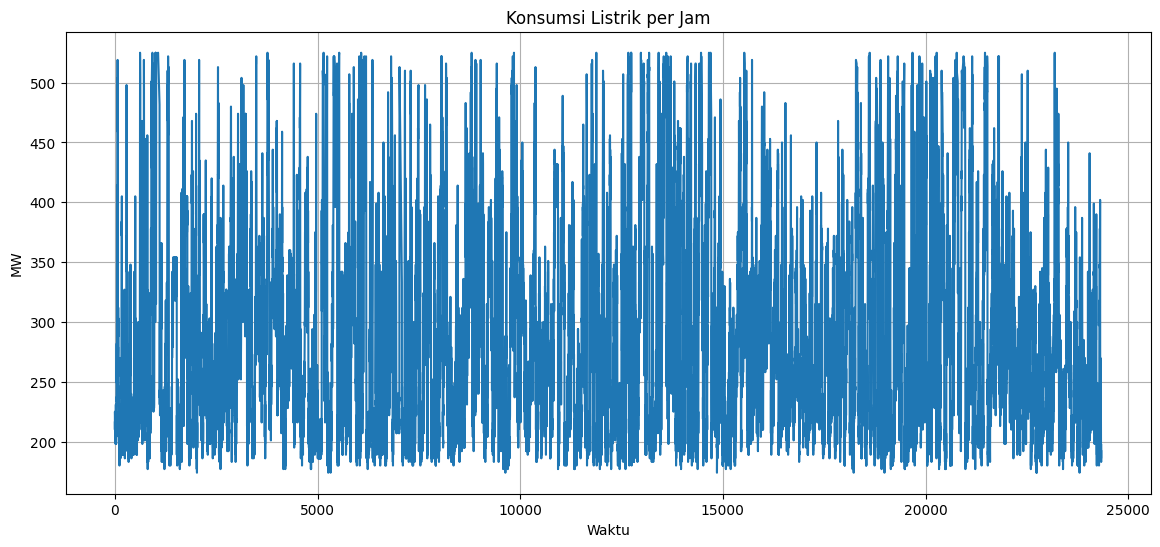

In [92]:
plt.figure(figsize=(14,6))
plt.plot(df_train_final.index, df_train_final['konsumsi_listrik'])
plt.title("Konsumsi Listrik per Jam")
plt.xlabel("Waktu")
plt.ylabel("MW")
plt.grid(True)
plt.show()

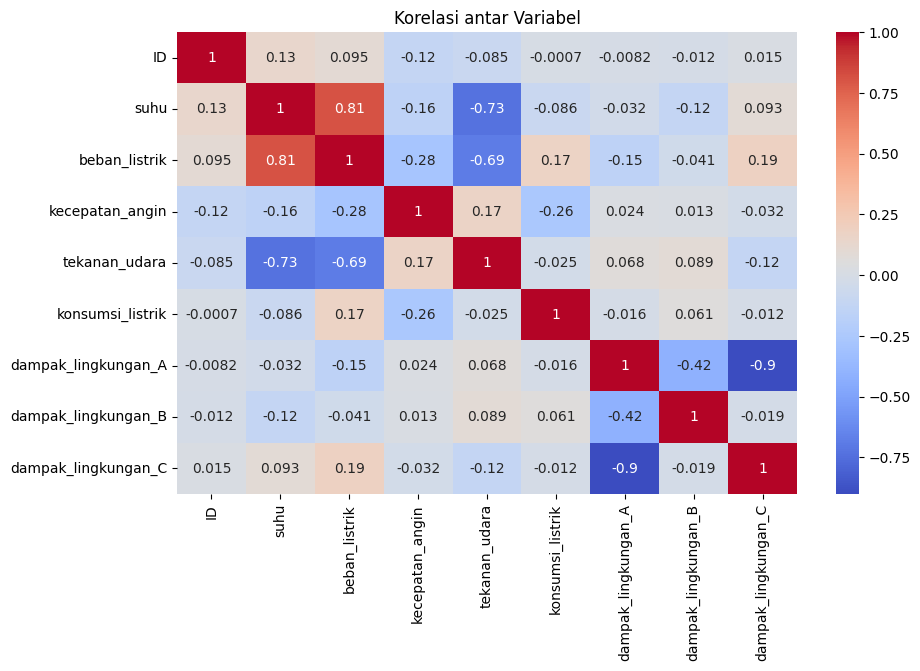

In [93]:
# Korelasi antar fitur
plt.figure(figsize=(10,6))
sns.heatmap(df_train_interpolated.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi antar Variabel")
plt.show()

## Modelling

### GRU

In [94]:
# Pisahkan fitur (X) dan target (y)
X = df_train_final.drop('konsumsi_listrik', axis=1).values
y = df_train_final['konsumsi_listrik'].values.reshape(-1, 1)

In [95]:
# Scaling fitur dan target secara terpisah
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [96]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        if y is not None:
            ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 48
X_seq, y_seq = create_dataset(X_scaled, y_scaled, TIME_STEPS)

X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)
print(f"Bentuk data training: {X_train.shape}")
print(f"Bentuk data validasi: {X_val.shape}\n")

Bentuk data training: (19430, 48, 15)
Bentuk data validasi: (4858, 48, 15)



In [97]:
# Fungsi untuk Membangun Model GRU yang Dapat Dituning
print("--- Menyiapkan Model untuk Tuning ---")
def build_model(hp):
    model = Sequential()
    
    # Tuning jumlah unit dan dropout rate
    hp_units_1 = hp.Int('units_1', min_value=80, max_value=160, step=16)
    hp_units_2 = hp.Int('units_2', min_value=40, max_value=80, step=16)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.05)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.05)
    hp_dense_units = hp.Int('dense_units', min_value=25, max_value=50, step=5)

    model.add(Bidirectional(GRU(units=hp_units_1, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dropout_1))
    model.add(Bidirectional(GRU(units=hp_units_2)))
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(units=hp_dense_units, activation='relu'))
    model.add(Dense(units=1))

    # Tuning learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

--- Menyiapkan Model untuk Tuning ---


In [98]:
# Proses Tuning
print("--- Memulai Pencarian Hyperparameter ---")
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=25,
    factor=3,
    directory='tuner_results_gru',
    project_name='konsumsi_listrik'
)

stop_early = EarlyStopping(monitor='val_loss', patience=7)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=1)


--- Memulai Pencarian Hyperparameter ---
Reloading Tuner from tuner_results_gru\konsumsi_listrik\tuner0.json


In [99]:
# Dapatkan model dan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"""
Hyperparameter terbaik yang ditemukan:
Units 1: {best_hps.get('units_1')}
Dropout 1: {best_hps.get('dropout_1'):.4f}
Units 2: {best_hps.get('units_2')}
Dropout 2: {best_hps.get('dropout_2'):.4f}
Dense Units: {best_hps.get('dense_units')}
Learning Rate: {best_hps.get('learning_rate')}
""")

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Hyperparameter terbaik yang ditemukan:
Units 1: 144
Dropout 1: 0.4000
Units 2: 72
Dropout 2: 0.4500
Dense Units: 50
Learning Rate: 0.0001



C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [100]:
# Training
print("\n--- Memulai Training Model ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


--- Memulai Training Model ---
Epoch 1/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - loss: 0.0840 - val_loss: 0.0498
Epoch 2/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0511 - val_loss: 0.0493
Epoch 3/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0415 - val_loss: 0.0388
Epoch 4/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0375 - val_loss: 0.0416
Epoch 5/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0371 - val_loss: 0.0383
Epoch 6/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0362 - val_loss: 0.0374
Epoch 7/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0363 - val_loss: 0.0381
Epoch 8/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.0346 - val_loss: 0.0358
Epoch 9/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 0.0341 - val_loss: 0.0434
Epoch 10/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0326 - val_loss: 0.0361
Epoch 11/25
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0328 - val_loss: 0.034

152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


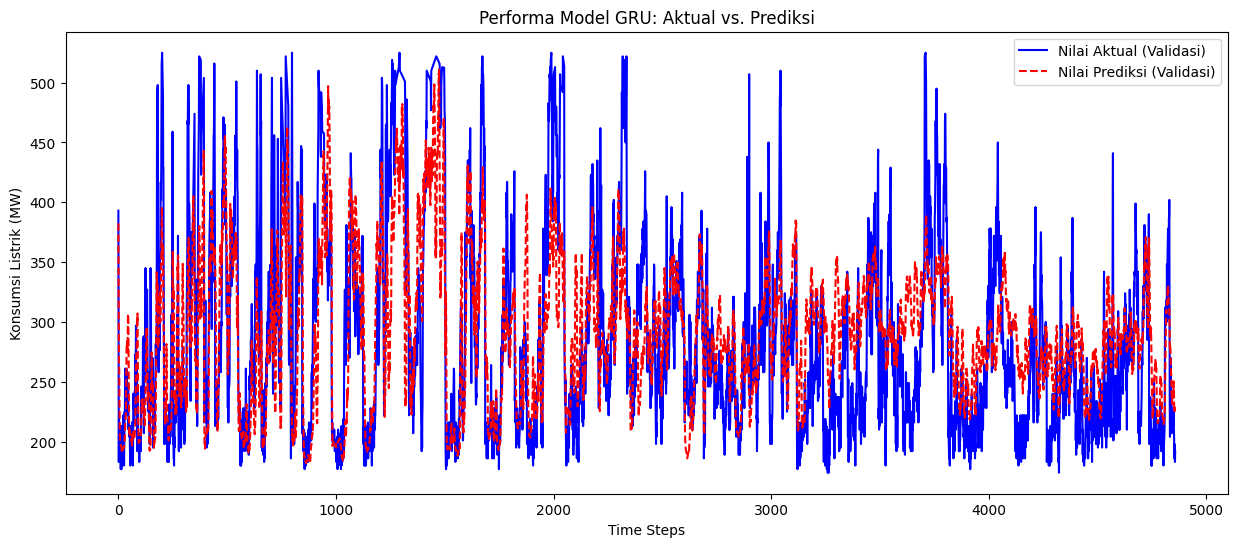

In [101]:
# Pastikan y_val_actual dan val_predictions sudah terdefinisi
y_val_actual = scaler_y.inverse_transform(y_val)
val_predictions_scaled = best_model.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)

# Visualisasi hasil pada data validasi
plt.figure(figsize=(15, 6))
plt.plot(y_val_actual, label='Nilai Aktual (Validasi)', color='blue')
plt.plot(val_predictions, label='Nilai Prediksi (Validasi)', color='red', linestyle='--')
plt.title('Performa Model GRU: Aktual vs. Prediksi')
plt.xlabel('Time Steps')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.show()

## Evaluasi

In [102]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(df_test, forecast):
    mse = mean_squared_error(df_test, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test, forecast)
    mape = mean_absolute_percentage_error(df_test, forecast)
    
    print("\nMetrik Evaluasi pada Data Validasi:")
    print(f'MSE = {mse:.4f}')
    print(f'RMSE = {rmse:.4f}')
    print(f'R² = {r2:.4f}')
    print(f'MAPE = {mape:.4f}')

# ### Evaluasi
print("\n--- Mengevaluasi Model ---")
val_predictions_scaled = best_model.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)
y_val_actual = scaler_y.inverse_transform(y_val)

evaluate_model(y_val_actual, val_predictions)


--- Mengevaluasi Model ---
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Metrik Evaluasi pada Data Validasi:
MSE = 3761.3581
RMSE = 61.3299
R² = 0.5064
MAPE = 0.1625


## Prediction

In [103]:
# Membuat File Submission
print("\n--- Membuat Prediksi untuk Data Test ---")
X_test_scaled = scaler_X.transform(df_test_final.values)

combined_data = np.concatenate([X_scaled[-TIME_STEPS:], X_test_scaled])

X_test_seq = []
for i in range(len(X_test_scaled)):
    X_test_seq.append(combined_data[i:i + TIME_STEPS])

X_test_seq = np.array(X_test_seq)

test_predictions_scaled = best_model.predict(X_test_seq)
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)

# Buat dataframe untuk submission
submission_df = pd.DataFrame({'ID': test_ids, 'konsumsi_listrik': test_predictions.flatten()})
submission_df.to_csv('submission_gru_advanced.csv', index=False)

print("\nFile submission 'submission_gru_advanced.csv' berhasil dibuat.")
print(submission_df.head())


--- Membuat Prediksi untuk Data Test ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

File submission 'submission_gru_advanced.csv' berhasil dibuat.
      ID  konsumsi_listrik
0  32184        224.847656
1  32185        219.340851
2  32186        217.729462
3  32187        215.097260
4  32188        217.462341



--- Menampilkan Visualisasi Prediksi pada Data Test ---


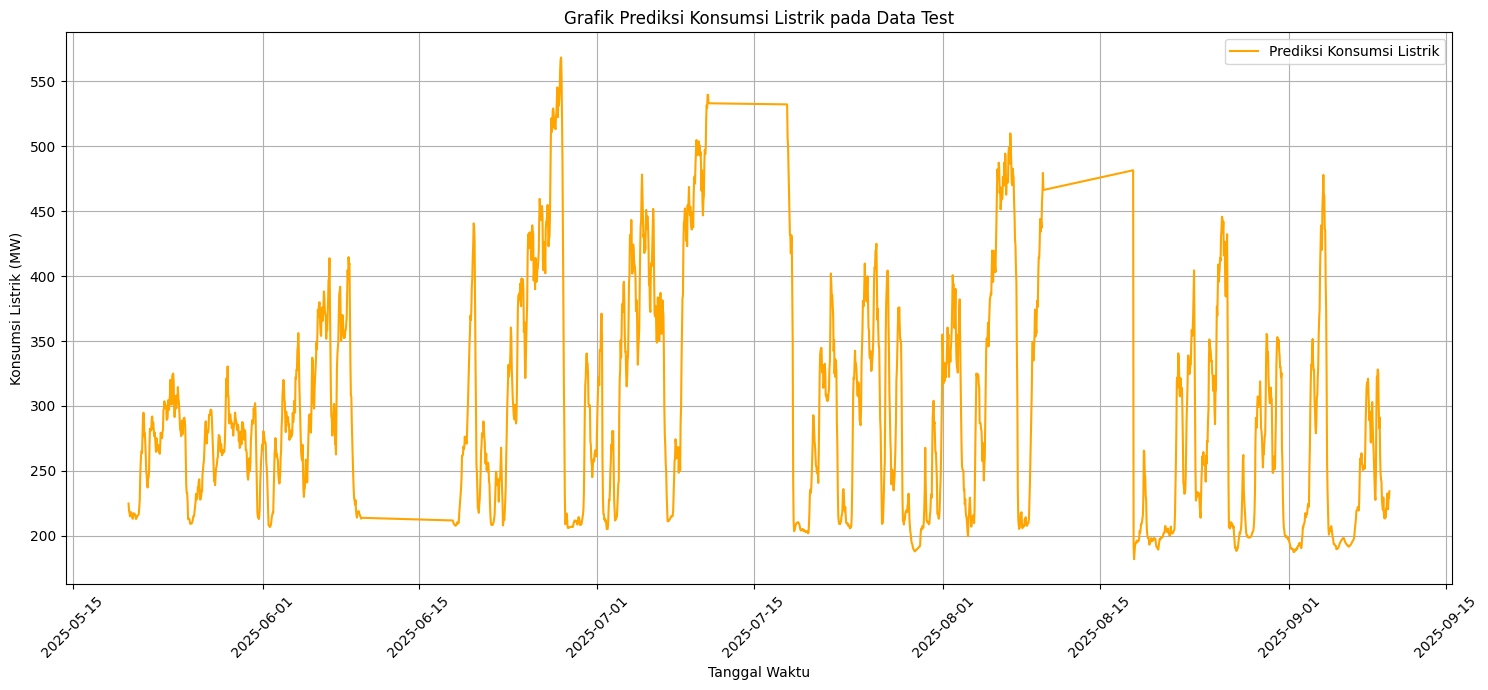

In [104]:
print("\n--- Menampilkan Visualisasi Prediksi pada Data Test ---")
plt.figure(figsize=(15, 7))
plt.plot(df_test['tanggal_waktu'], submission_df['konsumsi_listrik'], label='Prediksi Konsumsi Listrik', color='orange')
plt.title('Grafik Prediksi Konsumsi Listrik pada Data Test')
plt.xlabel('Tanggal Waktu')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()